# Healthcare Final Project

#### Edwin Ramirez, Darshil Desai, Rashi Saxena

In [450]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.feature_selection import f_classif, chi2, SelectKBest
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, make_scorer,roc_auc_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from scipy import stats
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
import re

from IPython.display import Image

In [2]:
# Reading in the data file
data = pd.read_csv('projectTrain.csv')
data.head()

,pdc,num_ip_post,total_los_post,num_op_post,num_er_post,num_ndc_post,num_gpi6_post,adjust_total_30d_post,generic_rate_post,post_ip_flag,...,generic_cost,brand_cost,ratio_G_total_cost,numofgen_post,numofbrand_post,generic_cost_post,brand_cost_post,ratio_G_total_cost_post,pdc_80_flag,drug_class
0,0.333333,0,0,4,0,15,5,14.466667,0.101382,0,...,30.621563,2984.927229,0.010155,2,13,196.359216,3001.501507,0.061403,0,*ANTIDIABETICS*
1,0.866667,0,0,5,0,16,4,18.000000,0.888889,0,...,720.788173,0.000000,1.000000,14,2,671.755173,735.661568,0.477297,1,*ANTIDIABETICS*
2,0.938889,0,0,7,0,11,4,8.600000,1.000000,0,...,179.538533,0.000000,1.000000,11,0,171.446621,0.000000,1.000000,1,*ANTICOAGULANTS*
3,0.077778,1,12,40,0,5,5,2.033333,1.000000,1,...,105.816329,0.000000,1.000000,5,0,335.826436,0.000000,1.000000,0,*ANTICOAGULANTS*
4,0.444444,0,0,12,1,15,9,14.833333,0.528090,0,...,630.173638,3265.595950,0.161758,8,7,75.988845,2054.400835,0.035669,0,*ANTIDIABETICS*


In [3]:
# Taking a look at the data dimensions
print ('This dataset has {} records and {} features'.format(data.shape[0], data.shape[1]))

This dataset has 2000 records and 94 features


## Determining the Categorical Features

In [393]:
#Gather all feature names
possible_cat_features = np.array(list(data))

feat_unique_vals = np.array([len(np.unique(data[i])) for i in possible_cat_features])

Variables that contain more than 2 unique values could potentially be considered a categorical variable that we have to encode with one hot encoding. We want to only encode categorical variables that contain more than 2 unique values because those that are binary are already encoded. Therefore, if we were to encode these as well, they would lead to a misrepresentation of the number of categorical variables we have. If we set a limit to the number of unique values, we'll have a set of variables that we could individually check in the data dictionary. In this scenario we'll set the maximum unique value to 20.

In [394]:
possible_features = np.unique(possible_cat_features[(feat_unique_vals >2) & (feat_unique_vals < 20)])

In [395]:
print("These are the following variables that may require one hot encoding: ")
count = 0
for val in possible_features:
    print((count,val) )
    count = count+1

These are the following variables that may require one hot encoding: 
(0, 'age_cat')
(1, 'age_grpN')
(2, 'idx_paytypN')
(3, 'idx_prodtypeN')
(4, 'num_er')
(5, 'num_er_post')
(6, 'num_ip')
(7, 'num_ip_post')
(8, 'pdc_cat')
(9, 'pre_CCI')
(10, 'pre_total_cat')
(11, 'regionN')


### Potential Categorical Features That May Require One Hot Encoding 

- age_cat
- age_grpN
- idx_paytypB
- idx_prodtypeN
- num_er
- num_er_post
- num_ip
- pdc_cat
- pre_CCI
- pre_total_cat
- regionN

After viewing the data dictionary, we see that num_er (number of visits), and num_ip (number of stays) are continuous variables, and additionaly we have to remove num_er_post because we will remove all variables related to the post index period to not affect our target variable `post_total_cost`.

In [396]:
index = [4,5,6,7,8]
possible_features = np.delete(possible_features, index)

In [397]:
possible_features

array(['age_cat', 'age_grpN', 'idx_paytypN', 'idx_prodtypeN', 'pre_CCI',
       'pre_total_cat', 'regionN'], dtype='<U26')

In [398]:
un_encoded = data[possible_features]

In [399]:
label_encoder = preprocessing.LabelEncoder()
cat_features2 = un_encoded.apply(label_encoder.fit_transform)
cat_features2.head()

,age_cat,age_grpN,idx_paytypN,idx_prodtypeN,pre_CCI,pre_total_cat,regionN
0,1,0,0,1,1,6,2
1,1,0,3,1,0,3,2
2,0,0,0,2,0,8,2
3,0,0,0,1,0,9,2
4,3,1,0,2,1,7,2


In [400]:
def one_hot_encode(df_column, data):
        feature = np.array(data[df_column])
        feature = feature.reshape((2000, 1))
        
        enc = preprocessing.OneHotEncoder()
        enc.fit(feature)
        
        #Transform the data
        onehotlabels = enc.transform(feature).toarray()
        no_cols = onehotlabels.shape[1]
        labels = []
        for ii in range(no_cols):
            labels.append(df_column + str(ii))
            
        one_hot_encoded = pd.DataFrame(onehotlabels)
        one_hot_encoded.columns = labels
        
        return one_hot_encoded

In [401]:
encoded = [one_hot_encode(i, cat_features2) for i in un_encoded.columns]

C:\Users\edalr\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\edalr\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you us

In [402]:
encoded_cats = pd.DataFrame()

In [403]:
for i in range(len(encoded)):
    encoded_cats = pd.concat([encoded_cats, encoded[i]], axis=1)

In [404]:
encoded_cats.head()

,age_cat0,age_cat1,age_cat2,age_cat3,age_cat4,age_cat5,age_grpN0,age_grpN1,age_grpN2,idx_paytypN0,...,pre_total_cat4,pre_total_cat5,pre_total_cat6,pre_total_cat7,pre_total_cat8,pre_total_cat9,regionN0,regionN1,regionN2,regionN3
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [405]:
encoded_cats.shape

(2000, 42)

Now we must include the additional binary categorical variables with our encoded categorical variables. We can do this by viewing all the total categorical variables that only contain 2 unique values.

In [406]:
other_cats = np.unique(possible_cat_features[(feat_unique_vals < 3)])

In [407]:
other_cats = np.setdiff1d(other_cats, possible_features)

In [408]:
other_cats = data[other_cats]

In [409]:
other_cats = [other_cats.columns[[not i for i in [bool(re.search('post', x)) for x in other_cats.columns]]]]

In [410]:
other_cats = np.array(other_cats)

In [411]:
other_cats[0]


array(['ALCOHOL_DRUG', 'ASTHMA', 'CARDIAC_ARRYTHMIA', 'CARDIAC_VALVULAR',
       'CEREBROVASCULAR', 'CHF', 'CHRONIC_KIDNEY', 'CHRONIC_PAIN_FIBRO',
       'COPD', 'Cancer_In_Situ', 'DEMENTIA', 'DEPRESSION', 'DIABETES',
       'DYSLIPIDEMIA', 'EPILEPSY_SEIZURE', 'HEPATITIS', 'HIV_AIDS',
       'HYPERTENSION', 'LIVER_GALLBLADDER_PANCREAS', 'Leukemia_Lymphoma',
       'MI_CAD', 'Metastatic', 'OSTEOARTHRITIS', 'Other_Cancer',
       'PARALYSIS', 'PEPTIC_ULCER', 'PERIPHERAL_VASCULAR',
       'RENAL_FAILURE', 'RHEUMATOLOGIC', 'SCHIZOPHRENIA',
       'SLEEP_DISORDERS', 'SMOKING', 'Solid_Tumor', 'THYROID',
       'drug_class', 'pdc_80_flag', 'pre_er_flag', 'pre_ip_flag', 'sexN'],
      dtype=object)

In [412]:
cat_vars = pd.concat([data[other_cats[0]], encoded_cats], axis= 1)
cat_vars.shape

(2000, 81)

## Determining the continuous variables

We can determine the same process for our continuous variables by simply removing all cate

In [418]:
non_continuous = list(possible_features) + list(other_cats[0])
non_continuous.append('post_total_cost')
non_continuous.append('pdc')
non_continuous.append('pdc_cat')

In [419]:
continuous_df = data.drop(non_continuous, axis=1)

#remove post index variables
cont_col = [continuous_df.columns[[not i for i in [bool(re.search('post', x)) for x in continuous_df.columns]]]]


In [420]:
continuous_df = continuous_df[cont_col[0]]

In [421]:
#Store target y
target_var = data['post_total_cost']

In [422]:
all_features = pd.concat([continuous_df, cat_vars], axis=1)
all_features.head()

,idx_copay,log_idx_copay,pre_ip_cost,pre_er_cost,pre_rx_cost,pre_op_cost,pre_total_cost,pre_medical_cost,num_ip,total_los,...,pre_total_cat4,pre_total_cat5,pre_total_cat6,pre_total_cat7,pre_total_cat8,pre_total_cat9,regionN0,regionN1,regionN2,regionN3
0,40.474500,3.700672,0.000000,0.0,3015.548793,1626.271037,4641.819829,1626.271037,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,4.060471,1.401299,0.000000,0.0,720.788173,479.349400,1200.137573,479.349400,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.010000,-4.605170,9794.292309,0.0,195.891492,781.502660,10771.686460,10575.794970,1,6,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,10.203185,2.322700,43476.276460,0.0,105.816329,186.932041,43769.024830,43663.208500,2,17,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,4.050485,1.398837,0.000000,0.0,3895.769588,2302.981377,6198.750965,2302.981377,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [423]:
#Drop NA values
all_features = pd.concat([all_features, target_var], axis=1)
all_features.dropna(inplace=True)

In [424]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(all_features.drop(columns = ['post_total_cost']), all_features['post_total_cost'], test_size=0.2, random_state=42)

In [425]:
X_train.to_csv("X_train.csv", index = False)
X_test.to_csv("X_test.csv", index = False)
y_train.to_csv("y_train.csv", index = False)
y_test.to_csv("y_test.csv", index = False)

### Export Data to use in R

In [427]:
cat_names = list(cat_vars.columns)
cat_names = pd.DataFrame(cat_names).T
cat_names

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
0,ALCOHOL_DRUG,ASTHMA,CARDIAC_ARRYTHMIA,CARDIAC_VALVULAR,CEREBROVASCULAR,CHF,CHRONIC_KIDNEY,CHRONIC_PAIN_FIBRO,COPD,Cancer_In_Situ,...,pre_total_cat4,pre_total_cat5,pre_total_cat6,pre_total_cat7,pre_total_cat8,pre_total_cat9,regionN0,regionN1,regionN2,regionN3


In [428]:
cont_names = list(continuous_df.columns)

In [429]:
pd.DataFrame(cont_names).T

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,idx_copay,log_idx_copay,pre_ip_cost,pre_er_cost,pre_rx_cost,pre_op_cost,pre_total_cost,pre_medical_cost,num_ip,total_los,...,generic_rate,log_pre_ip_cost,log_pre_er_cost,log_pre_op_cost,log_pre_rx_cost,numofgen,numofbrand,generic_cost,brand_cost,ratio_G_total_cost


In [430]:
cont_names = pd.DataFrame(cont_names).T

In [432]:
cat_names.to_csv("cat_names.csv", index = False)
cont_names.to_csv('cont_names.csv', index = False)

# AFTER R PROGRAMMING

# LOGISTIC REGRESSION

In [433]:
weights_ = np.array([-0.256602078, 0.003651686, -0.100005702, -0.487385694])

In [434]:
weights_

array([-0.25660208,  0.00365169, -0.1000057 , -0.48738569])

In [435]:
ad = all_features[all_features.drug_class == "*ANTIDIABETICS*"]

In [436]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(ad.drop(columns = ['pdc_80_flag']), ad['pdc_80_flag'], test_size=0.2, random_state=42)

In [437]:
X_test2["intr"] = 1

In [438]:
A = X_test2[["intr",  "adjust_total_30d", "age_cat0", "age_grpN0"]]

In [439]:
logit = lambda x: 1/(1+np.exp(-x))

coef = weights_

your_name = np.dot(A, coef)
log_your_name = [logit(i) for i in your_name]
classify = [0 if i < 0.5 else 1 for i in log_your_name]

In [445]:
accuracy = sum(classify == y_test2)/len(y_test2)
print("Accuracy of Logistic Regression Model: ", round(accuracy,2))

Accuracy of Logistic Regression Model:  0.62


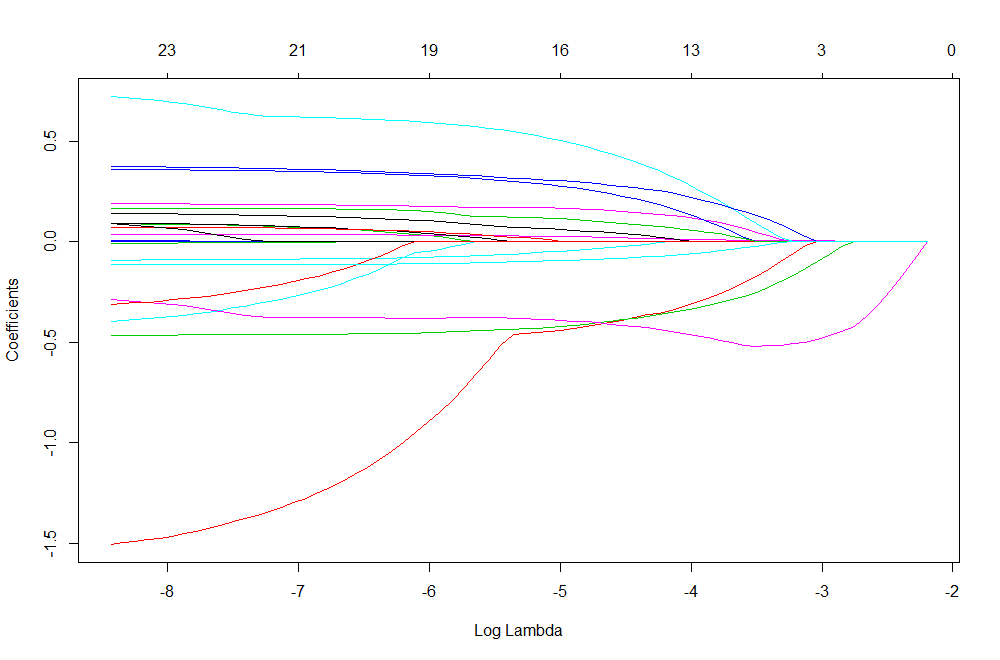

In [451]:
Image(filename="log1.png")

# LINEAR REGRESSION

In [446]:
f = open("lm.txt", "r")
print(f.read())


Call:
lm(formula = post_total_cost ~ ., data = lm_data2)

Residuals:
   Min     1Q Median     3Q    Max 
-34069  -6559  -2846   1785  72532 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          6.970e+03  3.406e+03   2.047  0.04087 *  
idx_copay            9.731e+00  1.658e+01   0.587  0.55745    
log_idx_copay       -2.410e+02  1.781e+02  -1.353  0.17634    
pre_er_cost          3.544e-01  3.219e-01   1.101  0.27108    
pre_op_cost          3.104e-01  6.895e-02   4.502 7.27e-06 ***
num_op               4.081e+01  4.756e+01   0.858  0.39096    
num_er               2.518e+02  5.076e+02   0.496  0.61991    
num_gpi6            -1.862e+02  1.543e+02  -1.207  0.22779    
adjust_total_30d     4.203e+01  3.643e+01   1.153  0.24889    
generic_rate        -2.402e+03  2.552e+03  -0.941  0.34670    
log_pre_op_cost     -4.767e+01  2.118e+02  -0.225  0.82200    
log_pre_rx_cost      1.174e+02  3.049e+02   0.385  0.70020    
numofbrand          -3.3

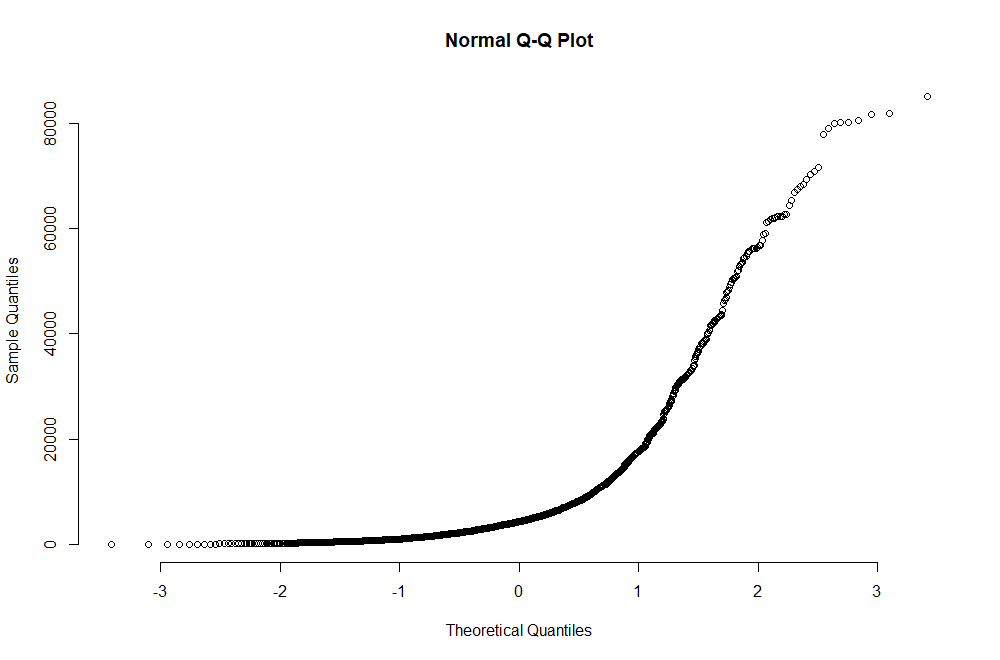

In [449]:
Image(filename='lm1.png')

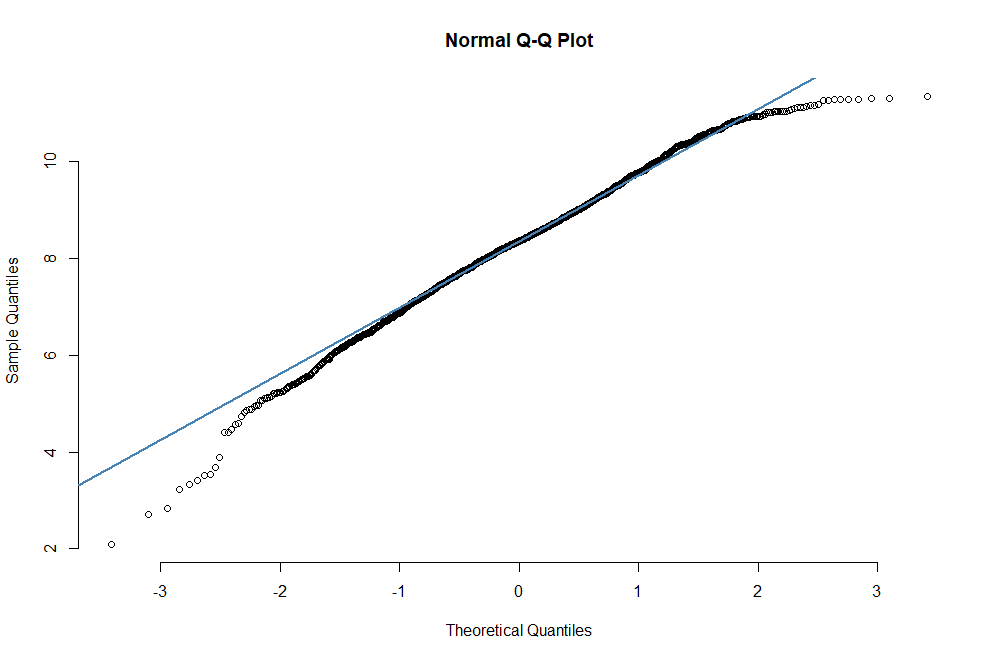

In [452]:
Image(filename='lm2.png')

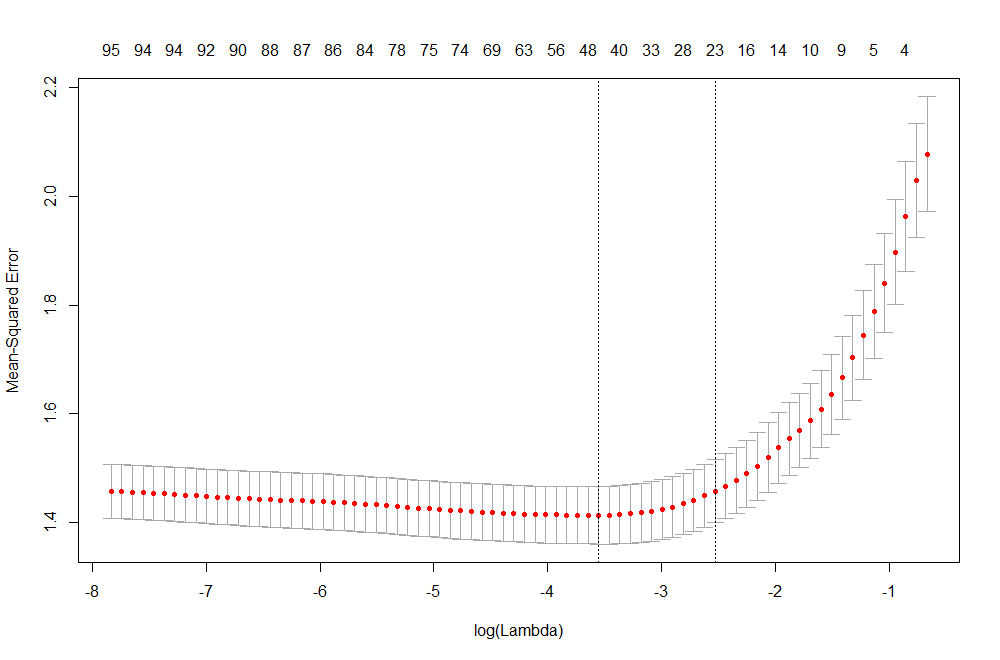

In [453]:
Image(filename='lm3.png')